In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
μReLU = [0.398942, 0.5, 0.398942, 0., -0.398942, 0.]
Eσ2ReLU = .5

μELU = [0.1605205722667549, 0.7615782918644975, 0.26157829186526865,-0.1373639885354897,-0.1373639885357776,0.2615782918541118,0.26157829187954007,-0.9352485495068876,-0.9352485493399296,5.048885656683824,5.048885656681984]
Eσ2ELU = 0.6449454174923381

def G(z,αℓ):
    """
    Stieltjes transformation of the MP distribution with ratio αℓ
    
    Parameters:
    -----------
    z : double
        argument of the function
    αℓ: double
        ratio of the MP distribution
    """
    if(z<0):
        res = (1 - z - αℓ - np.sqrt((z - 1 - αℓ)**2 - 4*αℓ))/(2*z*αℓ)
    else:
        res = 0
    return res

def dG(z,αℓ):
    """
    Derivative of the Stieltjes transformation of the MP distribution with ratio αℓ
    
    Parameters:
    -----------
    z : double
        argument of the function
    αℓ: double
        ratio of the MP distribution
    """
    if(z<0):
        res = (-z*(1 + αℓ) + (αℓ - 1)*(-1 + αℓ + np.sqrt((z - 1)**2 - 2*(1 + z)*αℓ + αℓ**2)))/(2*αℓ*z**2*np.sqrt(-4*αℓ + (1 - z + αℓ)**2))
    else:
        res = 0
    return res

def saddle(N,P,L,τ,step,D=30,ζ=10**(-8),yν=0.797885,yy=1,y=0,elu_relu=True,rate=0.2):
    """
    Iterative solution of the saddle-point eqs
    
    Parameters:
    -----------
    N : int
        number of random features
    P : int
        size of the training set
    L : int
        truncation of the activation function
    τ : array
        teacher's parameters, spherical Σₗ τₗ**2 = 1
    step : int
           step of the iteration 
    D : int
        input dimension
    ζ : double
        L2 regularization
    yν : double
         <yν>
    yy : double
         <y**2>
    y : double
        <y>
    elu_relu : bool
               if True ELU, else ReLU
    rate : double
           learning rate
    """
    if(step==1): # random initial conditions
        hm0_old,hq0_old,hv0_old = 5*np.random.rand(3)
        hm_old,hq_old,hv_old = 5*np.random.rand(3,L)
    else :
        m0_old,q0_old,v0_old,m_old,q_old,v_old,hm0_old,hq0_old,hv0_old,hm_old,hq_old,hv_old,Eg_old = saddle(N,P,L,τ,step-1,D,ζ,yν,yy,y,elu_relu,rate)
    
    if(elu_relu):
        μ0 = μELU[0] 
        μ = μELU[1:]
        Eσ2 = Eσ2ELU
    else :
        μ0 = μReLU[0]
        μ = μReLU[1:]
        Eσ2 = Eσ2ReLU
    
    μPerp = np.sqrt(Eσ2 - μ0**2 - np.array([μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum())
    
    α = np.array([N/math.comb(D,l) for l in range(1,L+1)])
    γ = α*np.reciprocal(hv_old)*(ζ + hv0_old)
    
    v = np.array([α[l]*(1 - γ[l]*G(-γ[l],α[l]))/hv_old[l] for l in range(0,L)])
    v0 = (1 - np.array([1 - γ[l]*G(-γ[l],α[l]) for l in range(0,L)]).sum())/(hv0_old+ζ)
    q = np.array([α[l]*(hm0_old**2 + hq0_old)/((ζ + hv0_old)*hv_old[l])*(γ[l]*G(-γ[l],α[l]) - γ[l]**2*dG(-γ[l],α[l])) + α[l]*(hm_old[l]**2 + hq_old[l])/(hv_old[l]**2)*(1 + γ[l]**2*dG(-γ[l],α[l]) - 2*γ[l]*G(-γ[l],α[l])) for l in range(0,L)])
    q0 = (hm0_old**2 + hq0_old)/(ζ + hv0_old)**2*(1 - np.array([1 - γ[l]**2*dG(-γ[l],α[l]) for l in range(0,L)]).sum())  + np.array([(hm_old[l]**2 + hq_old[l])/(hv_old[l]*(ζ+hv0_old))*(γ[l]*G(-γ[l],α[l]) - γ[l]**2*dG(-γ[l],α[l])) for l in range(0,L)]).sum()
    m = v*hm_old
    m0 = np.sqrt(N)*v0*hm0_old
    
    Vtot = μPerp**2*v0 + np.array([v[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    Qtot = μPerp**2*q0 + np.array([q[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    Mtot = np.array([m[l]*τ[l+1]*μ[l]/(np.sqrt(np.math.factorial(l+1))) for l in range(0,L)]).sum()
    
    hv = rate*(np.array([P/math.comb(D,l+1)*μ[l]**2/(np.math.factorial(l+1)*(1+Vtot)) for l in range(0,L)]) ) + (1-rate)*hv_old
    hv0 = rate*(P/N*μPerp**2/(1+Vtot)) + (1-rate)*hv0_old
    hq = rate*(np.array([P/math.comb(D,l+1)*μ[l]**2/np.math.factorial(l+1)*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*Mtot + Qtot  )/(1+Vtot)**2 for l in range(0,L)]) ) + (1-rate)*hq_old
    hq0 = rate*(P/N*μPerp**2*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*Mtot + Qtot  )/(1+Vtot)**2) + (1-rate)*hq0_old
    hm = rate*(np.array([P/math.comb(D,l+1)*μ[l]*τ[l+1]/np.sqrt(np.math.factorial(l+1))*yν/(1+Vtot) for l in range(0,L)])) + (1-rate)*hm_old
    hm0 = rate*(1/np.sqrt(N)*(P*μ0*y)/(P*μ0**2*v0 + (1+Vtot))) + (1-rate)*hm0_old
    
    Eg = 1/math.pi*np.arccos(Mtot/np.sqrt(Qtot))
    
    return m0,q0,v0,m,q,v,hm0,hq0,hv0,hm,hq,hv,Eg

def saddleAsymptI(P,k,τ,step,D=30,ζ=10**(-8),yν=0.797885,yy=1,y=0,elu_relu=True,rate=0.2):
    """
    Iterative solution of the saddle-point eqs, asymptotic limit N > P
    
    Parameters:
    -----------
    P : int
        size of the training set
    k : int
        order of log P / log D
    τ : array
        teacher's parameters, spherical Σₗ τₗ**2 = 1
    step : int
           step of the iteration 
    D : int
        input dimension
    ζ : double
        L2 regularization
    yν : double
         <yν>
    yy : double
         <y**2>
    y : double
        <y>
    elu_relu : bool
               if True ELU, else ReLU
    rate : double
           learning rate
    """
    if(step==1): # random initial conditions
        hmk_old,hqk_old,hvk_old = 5*np.random.rand(3)
    else :
        m0_old,q0_old,v0_old,m_old,q_old,v_old,hm0_old,hq0_old,hv0_old,hm_old,hq_old,hv_old,Eg_old = saddleAsymptI(P,k,τ,step-1,D,ζ,yν,yy,y,elu_relu,rate)
        hmk_old = hm_old[-1]
        hqk_old = hq_old[-1]
        hvk_old = hv_old[-1]
        
    if(elu_relu):
        μ0 = μELU[0] 
        μ = μELU[1:]
        Eσ2 = Eσ2ELU
    else :
        μ0 = μReLU[0]
        μ = μReLU[1:]
        Eσ2 = Eσ2ReLU
    
    μPerp = np.sqrt(Eσ2 - μ0**2 - np.array([μ[l]**2/(np.math.factorial(l+1)) for l in range(0,k)]).sum())
    
    vk = 1/(hvk_old + ζ)
    v = np.zeros(k-1)
    v = np.append(v,vk)
    v0 = 1/ζ
    qk = (hmk_old**2 + hqk_old)/(hvk_old + ζ)**2
    q = np.array([np.math.factorial(l+1)*τ[l+1]**2/(μ[l]**2)*yν**2 for l in range(0,k-1)])
    q = np.append(q,qk)
    q0 = 0
    mk = np.sqrt(np.math.factorial(k))*τ[k]/μ[k-1]*yν*(1-ζ*vk)
    m = np.array([np.sqrt(np.math.factorial(l+1))*τ[l+1]/μ[l]*yν for l in range(0,k-1)])
    m = np.append(m,mk)
    m0 = y/μ0
    
    Vtot = μPerp**2*v0 + np.array([v[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,k)]).sum()
    Qtot = μPerp**2*q0 + np.array([q[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,k)]).sum()
    Mtot = np.array([m[l]*τ[l+1]*μ[l]/(np.sqrt(np.math.factorial(l+1))) for l in range(0,k)]).sum()
    
    hvk = rate*(P/(math.comb(D,k)*np.math.factorial(k))*μ[k-1]**2/(1+Vtot) ) + (1 - rate)*hvk_old
    hv = np.full(k-1,np.inf)
    hv = np.append(hv,hvk)
    hv0 = 0
    hqk = rate*( P/math.comb(D,k)*μ[k-1]**2/np.math.factorial(k)*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*Mtot + Qtot  )/(1+Vtot)**2) + (1-rate)*hqk_old
    hq = np.full(k-1,np.inf)
    hq = np.append(hq,hqk)
    hq0 = 0
    hmk = rate*(P/math.comb(D,k)*μ[k-1]*τ[k]/np.sqrt(np.math.factorial(k))*yν/(1+Vtot)) + (1-rate)*hmk_old
    hm = np.full(k-1,np.inf)
    hm = np.append(hm,hmk)
    hm0 = 0
    
    Eg = 1/math.pi*np.arccos(Mtot/np.sqrt(Qtot))
    
    return m0,q0,v0,m,q,v,hm0,hq0,hv0,hm,hq,hv,Eg


def saddleAsymptII(N,P,L,τ,step,D=30,ζ=10**(-8),yν=0.797885,yy=1,y=0,elu_relu=True,rate=0.2):
    """
    Iterative solution of the saddle-point eqs, asymptotic limit N ~ P
    
    Parameters:
    -----------
    P : int
        size of the training set
    k : int
        order of log P / log D
    τ : array
        teacher's parameters, spherical Σₗ τₗ**2 = 1
    step : int
           step of the iteration 
    D : int
        input dimension
    ζ : double
        L2 regularization
    yν : double
         <yν>
    yy : double
         <y**2>
    y : double
        <y>
    elu_relu : bool
               if True ELU, else ReLU
    rate : double
           learning rate
    """
    if(step==1): # random initial conditions
        hm0_old,hq0_old,hv0_old = 10*np.random.rand(3)
        hmL_old,hqL_old,hvL_old = 10*np.random.rand(3)
    else :
        m0_old,q0_old,v0_old,m_old,q_old,v_old,hm0_old,hq0_old,hv0_old,hm_old,hq_old,hv_old,Eg_old = saddleAsymptII(N,P,L,τ,step-1,D,ζ,yν,yy,y,elu_relu,rate)
        hmL_old = hm_old[-1]
        hqL_old = hq_old[-1]
        hvL_old = hv_old[-1]
        
    if(elu_relu):
        μ0 = μELU[0] 
        μ = μELU[1:]
        Eσ2 = Eσ2ELU
    else :
        μ0 = μReLU[0]
        μ = μReLU[1:]
        Eσ2 = Eσ2ReLU
    
    μPerp = np.sqrt(Eσ2 - μ0**2 - np.array([μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum())
    
    αL = N/math.comb(D,L)
    γL = αL/(hvL_old)*(ζ + hv0_old)
    
    vL = αL*(1 - γL*G(-γL,αL))/hvL_old
    v = np.zeros(L-1)
    v = np.append(v,vL)
    v0 = γL*G(-γL,αL)/(hv0_old + ζ)
    qL = αL*(hm0_old**2 + hq0_old)/((ζ + hv0_old)*hvL_old )*(γL*G(-γL,αL)  - γL**2*dG(-γL,αL)) + αL*(hmL_old**2 + hqL_old)/(hvL_old**2)*(1 + γL**2*dG(-γL,αL) - 2*γL*G(-γL,αL) )
    q = np.array([np.math.factorial(l+1)*τ[l+1]**2/(μ[l]**2)*yν**2 for l in range(0,L-1)])
    q = np.append(q,qL)
    q0 = (hm0_old**2 + hq0_old)/((ζ + hv0_old)**2 )*γL**2*dG(-γL,αL) + (hmL_old**2 + hqL_old)/(hvL_old*(hv0_old+ζ))*( γL*G(-γL,αL) - γL**2*dG(-γL,αL))
    mL = vL*hmL_old
    m = np.array([np.sqrt(np.math.factorial(l+1))*τ[l+1]/μ[l]*yν for l in range(0,L-1)])
    m = np.append(m,mL)
    m0 = y/μ0
    
    Vtot = μPerp**2*v0 + np.array([v[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    Qtot = μPerp**2*q0 + np.array([q[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    Mtot = np.array([m[l]*τ[l+1]*μ[l]/(np.sqrt(np.math.factorial(l+1))) for l in range(0,L)]).sum()
    
    hvL = rate*(P/(math.comb(D,L)*np.math.factorial(L))*μ[L-1]**2/(1+Vtot) ) + (1 - rate)*hvL_old
    hv = np.full(L-1,np.inf)
    hv = np.append(hv,hvL)
    hv0 = rate*(P/N*μPerp**2/(1+Vtot)) + (1 - rate)*hv0_old
    hqL = rate*( P/math.comb(D,L)*μ[L-1]**2/np.math.factorial(L)*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*Mtot + Qtot  )/(1+Vtot)**2) + (1-rate)*hqL_old
    hq = np.full(L-1,np.inf)
    hq = np.append(hq,hqL)
    hq0 = rate*( P/N*μPerp**2*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*Mtot + Qtot  )/(1+Vtot)**2) + (1-rate)*hq0_old
    hmL = rate*(P/math.comb(D,L)*μ[L-1]*τ[L]/np.sqrt(np.math.factorial(L))*yν/(1+Vtot)) + (1-rate)*hmL_old
    hm = np.full(L-1,np.inf)
    hm = np.append(hm,hmL)
    hm0 = 0
    
    Eg = 1/math.pi*np.arccos(Mtot/np.sqrt(Qtot))
    
    return m0,q0,v0,m,q,v,hm0,hq0,hv0,hm,hq,hv,Eg

In [49]:
# Linear teacher, ELU activation, D = 30, N = 10^4

Ps = np.logspace(1,5,100)
maxstep = 1000

Egs = list()
EgsAsI1 = list()
EgsAsI2 = list()
EgsAsI3 = list()
EgsAsII = list()
q0s = list()
q1s = list()
q2s = list()
v0s = list()
v1s = list()
v2s = list()
m0s = list()
m1s = list()
m2s = list()
for p in Ps:
    m0,q0,v0,m,q,v,hm0,hq0,hv0,hm,hq,hv,Eg = saddle(10**4,p,3,np.array([0,1,0,0]),maxstep,rate=.4)
    Egs.append(Eg)
    q0s.append(q0)
    q1s.append(q[0])
    q2s.append(q[1])
    v0s.append(v0)
    v1s.append(v[0])
    v2s.append(v[1])
    m0s.append(m0)
    m1s.append(m[0])
    m2s.append(m[1])
    EgsAsI1.append(saddleAsymptI(p,1,np.array([0,1,0,0]),maxstep,rate=.4)[-1])
    EgsAsI2.append(saddleAsymptI(p,2,np.array([0,1,0,0]),maxstep,rate=.4)[-1])
    EgsAsI3.append(saddleAsymptI(p,3,np.array([0,1,0,0]),maxstep,rate=.4)[-1])
    EgsAsII.append(saddleAsymptII(10**4,p,3,np.array([0,1,0,0]),maxstep,rate=.4)[-1])
    

/tmp/ipykernel_8569/3133845945.py:192: RuntimeWarning: invalid value encountered in arccos
  Eg = 1/math.pi*np.arccos(Mtot/np.sqrt(Qtot))


In [50]:
PsNum = pd.read_csv("data/eluDATAzeta8.csv")["P"].tolist()
EgsNum = pd.read_csv("data/eluDATAzeta8.csv")["gen"].tolist()
EgsNumErr = np.array(pd.read_csv("data/eluDATAzeta8.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/eluDATAzeta8.csv")["T"].tolist())))

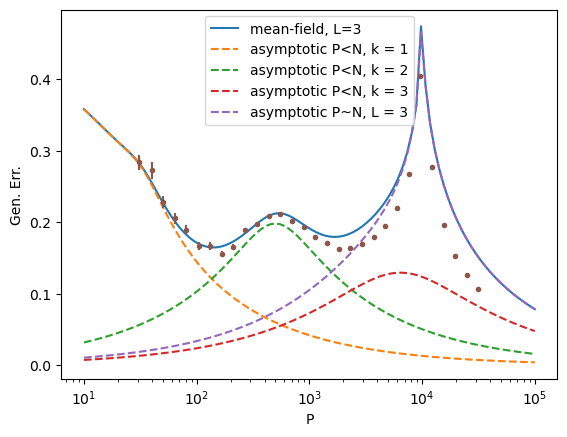

In [70]:
plt.plot(Ps,np.array(Egs),label="mean-field, L=3")
plt.plot(Ps,np.array(EgsAsI1),'--',label="asymptotic P<N, k = 1")
plt.plot(Ps,np.array(EgsAsI2),'--',label="asymptotic P<N, k = 2")
plt.plot(Ps,np.array(EgsAsI3),'--',label="asymptotic P<N, k = 3")
plt.plot(Ps,np.array(EgsAsII),'--',label="asymptotic P~N, L = 3")
plt.errorbar(PsNum,EgsNum,yerr=EgsNumErr,fmt='.')
plt.xscale('log')
plt.xlabel('P')
plt.ylabel('Gen. Err.')
plt.legend()
plt.show()

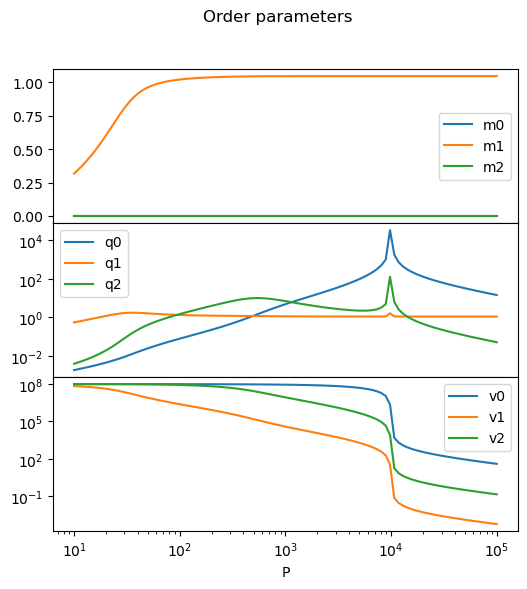

In [69]:
fig,(plM,plQ,plV) = plt.subplots(3,figsize=(6,6))
plt.subplots_adjust(hspace=0)
fig.suptitle("Order parameters")
plQ.plot(Ps,np.array(q0s),label="q0")
plQ.plot(Ps,np.array(q1s),label="q1")
plQ.plot(Ps,np.array(q2s),label="q2")
plM.plot(Ps,np.array(m0s),label="m0")
plM.plot(Ps,np.array(m1s),label="m1")
plM.plot(Ps,np.array(m2s),label="m2")
plV.plot(Ps,np.array(v0s),label="v0")
plV.plot(Ps,np.array(v1s),label="v1")
plV.plot(Ps,np.array(v2s),label="v2")
plQ.set(xscale='log',yscale='log')
plQ.set_xticks([])
plQ.set_xticks([],minor=True)
plM.set(xscale='log')
plM.set_xticks([])
plM.set_xticks([],minor=True)
plV.set(xscale='log',yscale='log')
plV.set_xlabel('P')
plQ.legend()
plM.legend()
plV.legend()

In [54]:
# Quadratic teacher, ELU activation, D = 30, N = 10^4

Ps = np.logspace(1,5,100)
maxstep = 1000

T2Egs = list()
T2EgsAsI1 = list()
T2EgsAsI2 = list()
T2EgsAsI3 = list()
T2EgsAsII = list()
T2q0s = list()
T2q1s = list()
T2q2s = list()
T2v0s = list()
T2v1s = list()
T2v2s = list()
T2m0s = list()
T2m1s = list()
T2m2s = list()
for p in Ps:
    m0,q0,v0,m,q,v,hm0,hq0,hv0,hm,hq,hv,Eg = saddle(10**4,p,3,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep)
    T2Egs.append(Eg)
    T2q0s.append(q0)
    T2q1s.append(q[0])
    T2q2s.append(q[1])
    T2v0s.append(v0)
    T2v1s.append(v[0])
    T2v2s.append(v[1])
    T2m0s.append(m0)
    T2m1s.append(m[0])
    T2m2s.append(m[1])
    T2EgsAsI1.append(saddleAsymptI(p,1,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-1])
    T2EgsAsI2.append(saddleAsymptI(p,2,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-1])
    T2EgsAsI3.append(saddleAsymptI(p,3,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-1])
    T2EgsAsII.append(saddleAsymptII(10**4,p,3,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-1])

/tmp/ipykernel_8569/3133845945.py:192: RuntimeWarning: invalid value encountered in arccos
  Eg = 1/math.pi*np.arccos(Mtot/np.sqrt(Qtot))


In [55]:
PsNum2 = pd.read_csv("data/eluDATAzeta8quad.csv")["P"].tolist()
EgsNum2 = pd.read_csv("data/eluDATAzeta8quad.csv")["gen"].tolist()
EgsNumErr2 = np.array(pd.read_csv("data/eluDATAzeta8quad.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/eluDATAzeta8quad.csv")["T"].tolist())))

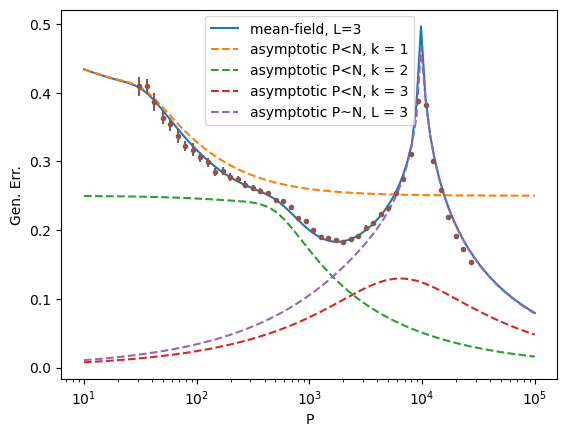

In [56]:
plt.plot(Ps,np.array(T2Egs),label="mean-field, L=3")
plt.plot(Ps,np.array(T2EgsAsI1),'--',label="asymptotic P<N, k = 1")
plt.plot(Ps,np.array(T2EgsAsI2),'--',label="asymptotic P<N, k = 2")
plt.plot(Ps,np.array(T2EgsAsI3),'--',label="asymptotic P<N, k = 3")
plt.plot(Ps,np.array(T2EgsAsII),'--',label="asymptotic P~N, L = 3")
plt.errorbar(PsNum2,EgsNum2,yerr=EgsNumErr2,fmt='.')
plt.xscale('log')
plt.xlabel('P')
plt.ylabel('Gen. Err.')
plt.legend()
plt.show()

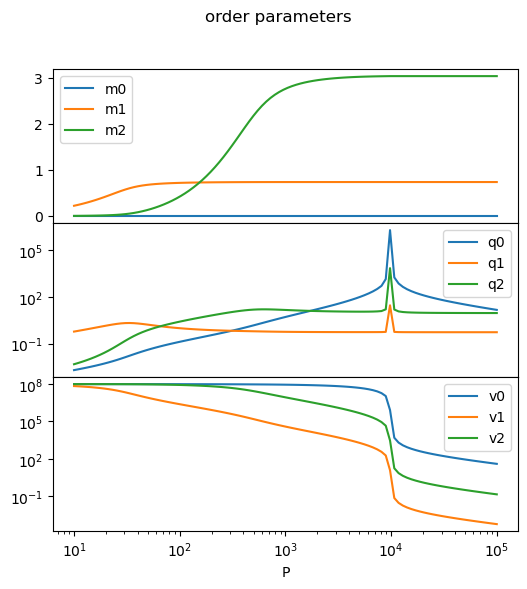

In [73]:
T2fig,(T2plM,T2plQ,T2plV) = plt.subplots(3,figsize=(6,6))
plt.subplots_adjust(hspace=0)
T2fig.suptitle("order parameters")
T2plQ.plot(Ps,np.array(T2q0s),label="q0")
T2plQ.plot(Ps,np.array(T2q1s),label="q1")
T2plQ.plot(Ps,np.array(T2q2s),label="q2")
T2plM.plot(Ps,np.array(T2m0s),label="m0")
T2plM.plot(Ps,np.array(T2m1s),label="m1")
T2plM.plot(Ps,np.array(T2m2s),label="m2")
T2plV.plot(Ps,np.array(T2v0s),label="v0")
T2plV.plot(Ps,np.array(T2v1s),label="v1")
T2plV.plot(Ps,np.array(T2v2s),label="v2")
T2plQ.set(xscale='log',yscale='log')
T2plQ.set_xticks([])
T2plQ.set_xticks([],minor=True)
T2plM.set(xscale='log')
T2plM.set_xticks([])
T2plM.set_xticks([],minor=True)
T2plV.set(xscale='log',yscale='log')
T2plV.set_xlabel('P')
T2plQ.legend()
T2plM.legend()
T2plV.legend()

In [43]:
# Scaling with D near the peak, linear teacher, ELU activation, α3 = 2.4, P/N = 0.5, N = α3*D^3/3!

Ds = np.logspace(1,3,100)
Ds = list(map(math.floor,Ds))
maxstep = 1000

α3 = 2.4
P_N = .5

T1_varD_Egs = list()
T1_varD_EgsAsII = list()
T1_varD_q0s = list()
T1_varD_q1s = list()
T1_varD_q2s = list()
T1_varD_v0s = list()
T1_varD_v1s = list()
T1_varD_v2s = list()
T1_varD_m0s = list()
T1_varD_m1s = list()
T1_varD_m2s = list()
for d in Ds:
    n = α3*d**3/np.math.factorial(3)
    p = P_N*n
    m0,q0,v0,m,q,v,hm0,hq0,hv0,hm,hq,hv,Eg = saddle(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)
    T1_varD_Egs.append(Eg)
    T1_varD_q0s.append(q0)
    T1_varD_q1s.append(q[0])
    T1_varD_q2s.append(q[1])
    T1_varD_v0s.append(v0)
    T1_varD_v1s.append(v[0])
    T1_varD_v2s.append(v[1])
    T1_varD_m0s.append(m0)
    T1_varD_m1s.append(m[0])
    T1_varD_m2s.append(m[1])
    T1_varD_EgsAsII.append(saddleAsymptII(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)[-1])

In [44]:
# Scaling with D near the peak, linear teacher, ELU activation, α3 = 1, P/N = 0.2, N = α3*D^3/3!

Ds = np.logspace(1,3,100)
Ds = list(map(math.floor,Ds))
maxstep = 1000

α3_2 = 1
P_N_2 = .2

T1_varD2_Egs = list()
T1_varD2_EgsAsII = list()
T1_varD2_q0s = list()
T1_varD2_q1s = list()
T1_varD2_q2s = list()
T1_varD2_v0s = list()
T1_varD2_v1s = list()
T1_varD2_v2s = list()
T1_varD2_m0s = list()
T1_varD2_m1s = list()
T1_varD2_m2s = list()
for d in Ds:
    n = α3_2*d**3/np.math.factorial(3)
    p = P_N_2*n
    m0,q0,v0,m,q,v,hm0,hq0,hv0,hm,hq,hv,Eg = saddle(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)
    T1_varD2_Egs.append(Eg)
    T1_varD2_q0s.append(q0)
    T1_varD2_q1s.append(q[0])
    T1_varD2_q2s.append(q[1])
    T1_varD2_v0s.append(v0)
    T1_varD2_v1s.append(v[0])
    T1_varD2_v2s.append(v[1])
    T1_varD2_m0s.append(m0)
    T1_varD2_m1s.append(m[0])
    T1_varD2_m2s.append(m[1])
    T1_varD2_EgsAsII.append(saddleAsymptII(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)[-1])

In [47]:
varD_DsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["D"].tolist()
varD_PsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["P"].tolist()
varD_NsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["N"].tolist()
varD_EgsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["gen"].tolist()
varD_EgsNumErr = np.array(pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["T"].tolist())))
varD_DsNum_chow = pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["D"].tolist()
varD_EgsNum_chow = pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["gen"].tolist()
varD_EgsNumErr_chow = np.array(pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["T"].tolist())))

varD2_DsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["D"].tolist()
varD2_PsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["P"].tolist()
varD2_NsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["N"].tolist()
varD2_EgsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["gen"].tolist()
varD2_EgsNumErr = np.array(pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["T"].tolist())))

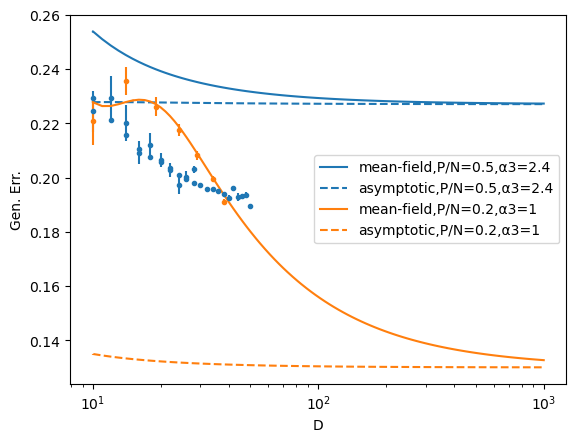

In [48]:
plt.plot(Ds,np.array(T1_varD_Egs),label="mean-field,P/N=0.5,α3=2.4",color="C0")
plt.plot(Ds,np.array(T1_varD_EgsAsII),'--',label="asymptotic,P/N=0.5,α3=2.4",color="C0")
plt.errorbar(varD_DsNum,varD_EgsNum,yerr=varD_EgsNumErr,fmt='.',color="C0")
plt.errorbar(varD_DsNum_chow,varD_EgsNum_chow,yerr=varD_EgsNumErr_chow,fmt='.',color="C0")

plt.plot(Ds,np.array(T1_varD2_Egs),label="mean-field,P/N=0.2,α3=1",color="C1")
plt.plot(Ds,np.array(T1_varD2_EgsAsII),'--',label="asymptotic,P/N=0.2,α3=1",color="C1")
plt.errorbar(varD2_DsNum,varD2_EgsNum,yerr=varD2_EgsNumErr,fmt='.',color="C1")
plt.xscale('log')
plt.xlabel('D')
plt.ylabel('Gen. Err.')
plt.legend()
plt.show()